In [1]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM, AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
import torch
from IPython.display import display
import time

model_id = "mistral-community/pixtral-12b"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, use_fast=True)

# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model with 4-bit quantization and map to CUDA
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype="auto",
    quantization_config=nf4_config,
    _attn_implementation='eager') # use _attn_implementation='eager' to disable flash attention

c:\Users\Andrea.Bagante\AppData\Local\pypoetry\Cache\virtualenvs\id-models-comparison-B_ZlXsb4-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 6/6 [00:47<00:00,  7.84s/it]


In [2]:
def model_inference(messages, path_image):
    
    start_time = time.time()

    image = Image.open(path_image)

    # Prepare prompt with image token
    prompt = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=500,
        do_sample=False,
        temperature=0.0,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    #display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

In [ ]:
message = [
    {
        "role": "user", "content": [
            {"type": "image"},
            {"type": "text", "content": "OCR the text of the image. Extract the text of the following fields and put it in a JSON format: \
            'Cognome', 'Nome', 'Nato il', 'a',\
            'Cittadinanza', 'Residenza', 'Via',\
            'Stato civile', 'Professione', 'Statura'.\
            Respond only with valid JSON. Do not write an introduction or summary"}
        ]
    }
]

#path_image = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\20241212_160419.jpg" # fronte
path_image = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\20241212_160455.jpg" # retro


# inference
model_inference(message, path_image)

You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transformers v4.47.
c:\Users\Andrea.Bagante\AppData\Local\pypoetry\Cache\virtualenvs\id-models-comparison-B_ZlXsb4-py3.11\Lib\site-packages\transformers\generation\configuration_utils.py:626: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 8.96837306022644
```json
{
  "Cognome": "BOGGIAN",
  "Nome": "STEFANO",
  "Nato il": "21/08/1979",
  "a": "PADOVA (PD)",
  "Cittadinanza": "ITALIANA",
  "Residenza": "ABANO TERME(PD)",
  "Via": "VIALE CASSINO Num. II",
  "Stato civile": "CONIUGATO",
  "Professione": "INGEGNERE",
  "Statura": "190 cm"
}
```


In [ ]:
# ```json
# {
#   "Cognome": "BOGGIAN",
#   "Nome": "STEFANO",
#   "Nato il": "21/08/1979",
#   "a": "PADOVA (PD)",
#   "Cittadinanza": "ITALIANA",
#   "Residenza": "ABANO TERME(PD)",
#   "Via": "VIALE CASSINO Num. II",
#   "Stato civile": "CONIUGATO",
#   "Professione": "INGEGNERE",
#   "Statura": "190 cm"
# }
# ```

In [4]:
from enum import Enum

class DocumentROIs(Enum):
    
    CARTA_IDENTITA_CARTACEA = {
        "cognome": [(50, 50, 300, 40)],
        "nome": [(50, 85, 300, 40)],
        "data_nascita" : [(50, 113, 300, 37)],
        "luogo_nascita": [(50, 175, 300, 40)],
        "cittadinanza": [(50, 205, 400, 40)],
        "residenza_citta": [(50, 235, 400, 40)],
        "residenza_via": [(50, 270, 400, 40)],
        "stato_civile": [(50, 300, 300, 40)],
        "professione": [(50, 330, 300, 40)],
        "altezza": [(150, 400, 200, 40)],
        "capelli": [(150, 438, 200, 40)],
        "occhi": [(150, 470, 300, 40)],
        # "segni_particolari": [(70, 510, 350, 150)]
}

    CARTA_IDENTITA_CARTACEA_RETRO = {
        "data_scadenza": [(80, 180, 250, 80)],
        "id": [(140, 430, 300, 60)],
        "comune_emissione" : [(565, 230, 350, 80)],
        "id2": [(670, 370, 250, 60)],
        "cognome": [(560, 480, 300, 40)],
        "nome": [(560, 520, 300, 40)],
    }

In [5]:
import cv2
import numpy as np

def preprocessing(image_path):
    original_image = cv2.imread(image_path)

    (H, W) = original_image.shape[:2]
    # Necessario fare resize se l'immagine supera determinati valori, altrimenti ritorna "unknown C## error"
    if H > 2000 or W > 1500:
        if H > 2000:
            H = 2000
        if W > 1500:
            W = 1500
        try:
             preprocessed_image = cv2.resize(original_image, [W, H], interpolation=cv2.INTER_CUBIC)
        except Exception as ex:
             raise Exception(str(ex))
    else:
        preprocessed_image = original_image

    return preprocessed_image

In [6]:
def base_alignement(image):

    ref_image_path = "C:\\codice\\gitgit\\ai-id-extractor\\app\\classes\\extractor\\resources\\ref_carta_identita_cartacea.jpg"
    reference_image = cv2.imread(ref_image_path)

    reference = cv2.resize(reference_image, [986, 657], interpolation=cv2.INTER_CUBIC)
    reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)

    image_to_move = cv2.resize(image, [986, 657], interpolation=cv2.INTER_CUBIC)
    image_to_move = cv2.cvtColor(image_to_move, cv2.COLOR_BGR2GRAY)

    # Rileva i punti chiave e descrittori usando SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(reference, None)
    kp2, des2 = sift.detectAndCompute(image_to_move, None)

    # Usa FLANN per trovare le corrispondenze tra i punti chiave
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Filtra le corrispondenze usando il rapporto di Lowe
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    # Estrae le coordinate dei punti chiave corrispondenti
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    # Calcola la matrice di omografia
    M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Applica la trasformazione all'immagine
    h, w= reference.shape
    aligned_img = cv2.warpPerspective(image_to_move, M, (w, h))

    return aligned_img


In [7]:
def save_temp_image(image, temp_image_path):
    cv2.imwrite(temp_image_path, image)

In [8]:
image_path = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\20241212_160419.jpg" # fronte
#image_path = "C:\\Users\\Andrea.Bagante\\Desktop\\CI_cartacea\\20241212_160455.jpg" # retro
#image = cv2.imread(image_path) 
image = preprocessing(image_path)

In [9]:
def model_inference(messages, path_image):
    
    start_time = time.time()
    
    image = Image.open(path_image)

    # Prepare prompt with image token
    prompt = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=500,
        do_sample=False,
        temperature=0.0,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


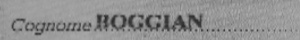

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.7313270568847656
Cognome ROGGIAN
None


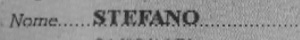

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.43416833877563477
Name: STEFANO
None


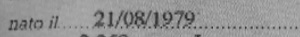

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.8105745315551758
nato il 21/06/1979
None


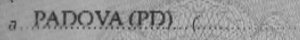

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.43758130073547363
PADOVA (PD)
None


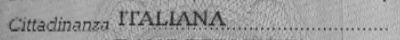

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.5477051734924316
Cittadinanza ITALIANA
None


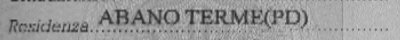

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.7995266914367676
Residenz29
ABANO TERME(PD)
None


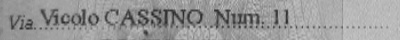

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.8320600986480713
vía VICOLO CASSINO Num. 11
None


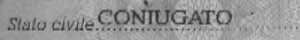

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.5006535053253174
Stato civile CONIUGATO
None


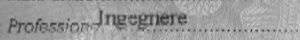

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.3514580726623535
Professional Ingenuity
None


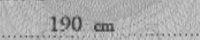

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.33646488189697266
190 cm
None


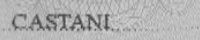

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Inference time: 0.3463726043701172
CASTANI
None


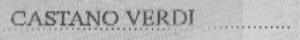

Inference time: 0.4527409076690674
CASTANO VERDI
None


In [10]:
from tempfile import mkstemp
import os
import time

temp_image_path = None
aligned_image = base_alignement(image)
v = getattr(DocumentROIs, "CARTA_IDENTITA_CARTACEA").value
for name, roi in v.items():
    x, y, w, h = roi[0]
    roi_image = aligned_image[y:y+h, x:x+w]

    # cv2.imshow('image', roi_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    temp_file, temp_image_path = mkstemp(suffix=".jpg")
    with os.fdopen(temp_file, "wb") as f:
        save_temp_image(roi_image, temp_image_path)
        message = [
            {
                "role": "user", "content": [
                    {"type": "image"},
                    {"type": "text", "content": "Act as an OCR. OCR the text of the image. \
                    1. Recognize all visible text in the image as accurately as possible. \
                    2. Maintain the original structure and formatting of the text. \
                    3. If any words or phrases are unclear, indicate this with just one [unclear] in your transcription. \
                    4. Provide only the transcription without any additional comments. Just write the transcription, no comments or other text! \
                    5. Remember to DO NOT add any other text or comment other than the transcription!"},
                    
                ]
            }
        ]

        result = model_inference(message, temp_image_path)
        print(result)